In [1]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following 

In [2]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

  01 wt_0h 02 wt_2h 03 arm2b.1_0h 04 arm2b.1_2h 05 arm2b.2_0h 06 arm2b.2_2h
1 1.016305 17.18804     0.7388397      14.55389            NA            NA
2 0.698985 18.04257     1.2085971      14.65512            NA            NA
3 1.407694 16.14856     1.1198716      14.96306            NA            NA
4       NA       NA            NA            NA            NA            NA
5 1.242575 23.48078     1.1172871      27.66663            NA            NA
6 1.037660 24.64816     0.7422618      25.63557            NA            NA
  07 flg22_0h 08 flg22_2h   Group
1   0.6113201    86.22295 Trial01
2   1.2483305    86.22295 Trial01
3   1.3103934    85.62736 Trial01
4          NA          NA    <NA>
5          NA          NA Trial02
6          NA          NA Trial02
# A tibble: 6 × 3
  ind           Group   values
  <chr>         <chr>    <dbl>
1 01 wt_0h      Trial01  1.02 
2 02 wt_2h      Trial01 17.2  
3 03 arm2b.1_0h Trial01  0.739
4 04 arm2b.1_2h Trial01 14.6  
5 05 arm2b.2_0h Trial01 NA

# A tibble: 6 × 3
  Treatment Trial      VALUE
  <chr>     <chr>      <dbl>
1 01 wt_0h  Trial01  0.00702
2 01 wt_0h  Trial01 -0.156  
3 01 wt_0h  Trial01  0.149  
4 02 wt_2h  Trial01  1.24   
5 02 wt_2h  Trial01  1.26   
6 02 wt_2h  Trial01  1.21   


[1] 16 17

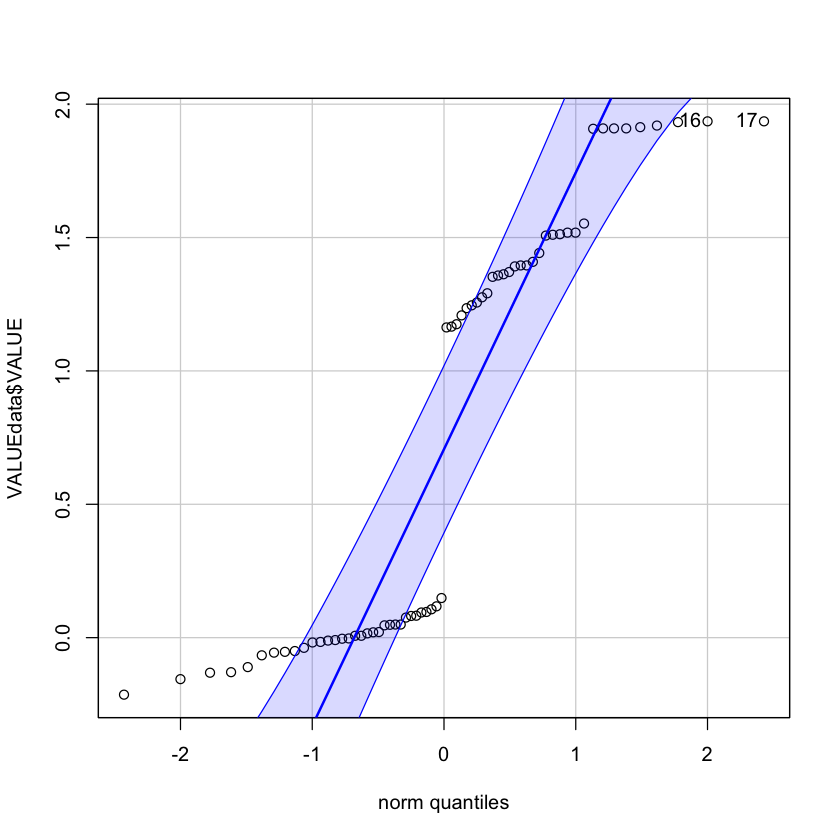

In [3]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
VALUEdata$VALUE <- log10(VALUEdata$VALUE)
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
  -119.2    -97.3     69.6   -139.2       56 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.36890 -0.62677  0.02409  0.46928  2.15441 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Trial    (Intercept) 0.0008107 0.02847 
 Residual             0.0066498 0.08155 
Number of obs: 66, groups:  Trial, 4

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            -4.881e-11  2.751e-02  2.148e+01   0.000    1.000    
Treatment02 wt_2h       1.348e+00  3.329e-02  6.199e+01  40.493   <2e-16 ***
Treatment03 arm2b.1_0h  3.658e-03  4.190e-02  6.538e+01   0.087    0.931    
Treatment04 arm2b.1_2h  1.289e+00  4.190e-02  6.538e+01  30.765   <2e-16 ***
Treatment05 arm2b.2_0h -3.658e-03  4.190e-02  6.538e+01

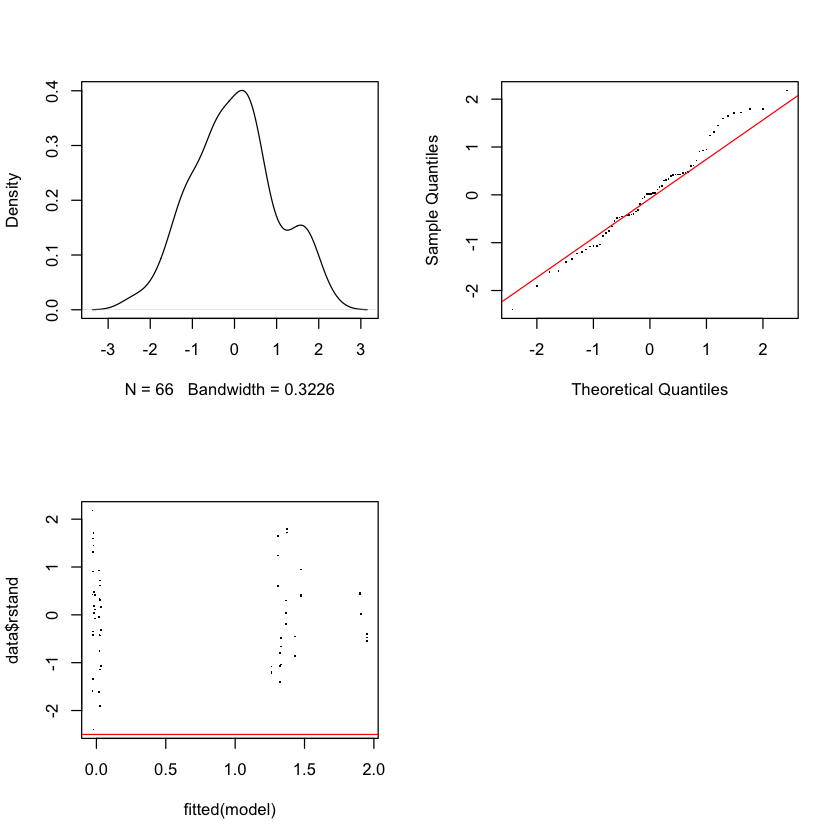

In [4]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [5]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq        Mean Sq          NumDF       DenDF          F value   
 Min.   :39.8   Min.   :5.686   Min.   :7   Min.   :60.41   Min.   :855  
 1st Qu.:39.8   1st Qu.:5.686   1st Qu.:7   1st Qu.:60.41   1st Qu.:855  
 Median :39.8   Median :5.686   Median :7   Median :60.41   Median :855  
 Mean   :39.8   Mean   :5.686   Mean   :7   Mean   :60.41   Mean   :855  
 3rd Qu.:39.8   3rd Qu.:5.686   3rd Qu.:7   3rd Qu.:60.41   3rd Qu.:855  
 Max.   :39.8   Max.   :5.686   Max.   :7   Max.   :60.41   Max.   :855  
     Pr(>F)         
 Min.   :6.448e-58  
 1st Qu.:6.448e-58  
 Median :6.448e-58  
 Mean   :6.448e-58  
 3rd Qu.:6.448e-58  
 Max.   :6.448e-58  


Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                    Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0            1.348068   0.033291  40.493    <0.01 ***
03 arm2b.1_0h - 01 wt_0h == 0       0.003658   0.041900   0.087   1.0000    
04 arm2b.1_2h - 01 wt_0h == 0       1.289067   0.041900  30.765    <0.01 ***
05 arm2b.2_0h - 01 wt_0h == 0      -0.003658   0.041900  -0.087   1.0000    
06 arm2b.2_2h - 01 wt_0h == 0       1.450217   0.041900  34.611    <0.01 ***
07 flg22_0h - 01 wt_0h == 0         0.006620   0.036388   0.182   1.0000    
08 flg22_2h - 01 wt_0h == 0         1.925787   0.036388  52.924    <0.01 ***
03 arm2b.1_0h - 02 wt_2h == 0      -1.344410   0.041900 -32.086    <0.01 ***
04 arm2b.1_2h - 02 wt_2h == 0      -0.059001   0.041900  -1.408   0.8497    
05 arm2b.2_0h - 02

Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”


     01 wt_0h      02 wt_2h 03 arm2b.1_0h 04 arm2b.1_2h 05 arm2b.2_0h 
          "a"          "bc"           "a"           "b"           "a" 
06 arm2b.2_2h   07 flg22_0h   08 flg22_2h 
          "c"           "a"           "d" 
